# Wave Identification Forecast Example

Wave identification of Yang et al (2003) method using wave_identify module. \
Files are ECMWF medium range from TIGGE database.\
Analsysis is T00 timestep of control forecasts, forecast is initialise at 00Z on 26/01/2026

In [ ]:
import sys
#specify src path for module
sys.path.append('../src/')
import wave_identify as W
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#added for divergence calculation and contour plotting. Can also use to plot vorticity for R1 and WMRG waves
from metpy.calc import divergence,vorticity
import cartopy.crs as ccrs

# Load files
Should be an xarray file of zonal wind, meridional wind and geopotential height. Can be at one pressure level or multiple. If just one pressure level the data will need to be adjusted to have a pressure dimension of length 1 (e.g. using ```nc.expand_dims({'pressure':[850]})```)

In [2]:
input_dir = '../data/'

#Load analysis file which contains u, v, z 
input_an_fname = f'{input_dir}*_cfan_*.nc'
an_nc = xr.open_mfdataset(input_an_fname)


In [3]:
an_nc

<xarray.Dataset> Size: 152MB
Dimensions:    (time: 173, level: 2, latitude: 51, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
  * level      (level) int32 8B 200 850
  * time       (time) datetime64[ns] 1kB 2025-11-01 ... 2026-01-26
Data variables:
    u          (time, level, latitude, longitude) float64 51MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 51MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    gh         (time, level, latitude, longitude) float64 51MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2026-01-28 12:14:58 GMT by grib_to_netcdf-2.39.4: /opt/ecmw...

In [4]:

fc_nc = xr.open_mfdataset(f'{input_dir}*_cf_*.nc')

In [5]:
fc_nc

<xarray.Dataset> Size: 54MB
Dimensions:    (longitude: 360, latitude: 51, level: 2, time: 61)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
  * level      (level) int32 8B 200 850
  * time       (time) datetime64[ns] 488B 2026-01-26 ... 2026-02-10
Data variables:
    u          (time, level, latitude, longitude) float64 18MB dask.array<chunksize=(61, 2, 51, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 18MB dask.array<chunksize=(61, 2, 51, 360), meta=np.ndarray>
    gh         (time, level, latitude, longitude) float64 18MB dask.array<chunksize=(61, 2, 51, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2026-01-28 12:51:43 GMT by grib_to_netcdf-2.39.4: /opt/ecmw...

In [6]:
#fc_nc is at 6 hourly intervals, an_nc is at 12 hourly intervals so must correct
fc_nc = fc_nc.sel(time=fc_nc.time.dt.hour.isin([0,12]))

# Combine files

Combine analysis and forecast files such that the total file is 60 days long

In [7]:
fc_len = fc_nc.time.size
an_len = 60*2 -fc_len           #length required for 60 days at 12 hourly intervals

In [8]:
#get the correct time slice for analysis data
fc_start = fc_nc.time[0].values
an_start = (fc_start - np.timedelta64(an_len*12,'h'))
an_start = an_start-np.timedelta64(12,'h') if pd.Timestamp(an_start).hour==12 else an_start
an_end = fc_start - np.timedelta64(12,'h')

In [9]:
an_nc = an_nc.sel(time=slice(an_start,an_end))

In [10]:
an_nc

<xarray.Dataset> Size: 79MB
Dimensions:    (time: 90, level: 2, latitude: 51, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
  * level      (level) int32 8B 200 850
  * time       (time) datetime64[ns] 720B 2025-12-12 ... 2026-01-25T12:00:00
Data variables:
    u          (time, level, latitude, longitude) float64 26MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 26MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    gh         (time, level, latitude, longitude) float64 26MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2026-01-28 12:14:58 GMT by grib_to_netcdf-2.39.4: /opt/ecmw...

In [11]:
#combine analysis and forecast data
nc = xr.concat([an_nc,fc_nc],dim='time')

In [12]:
nc

<xarray.Dataset> Size: 107MB
Dimensions:    (time: 121, level: 2, latitude: 51, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
  * level      (level) int32 8B 200 850
  * time       (time) datetime64[ns] 968B 2025-12-12 ... 2026-02-10
Data variables:
    u          (time, level, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    gh         (time, level, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2026-01-28 12:14:58 GMT by grib_to_netcdf-2.39.4: /opt/ecmw...

# Make correct format

May need to adjust dims depending on input file to have dims time,pressure,latitude,longitude


In [13]:
nc = nc.rename({'level':'pressure'})

In [14]:
nc


<xarray.Dataset> Size: 107MB
Dimensions:    (time: 121, pressure: 2, latitude: 51, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
  * pressure   (pressure) int32 8B 200 850
  * time       (time) datetime64[ns] 968B 2025-12-12 ... 2026-02-10
Data variables:
    u          (time, pressure, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    v          (time, pressure, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
    gh         (time, pressure, latitude, longitude) float64 36MB dask.array<chunksize=(1, 2, 51, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2026-01-28 12:14:58 GMT by grib_to_netcdf-2.39.4: /opt/ecmw...

# Run filtering function

In [15]:
#additional inputs can be included, but defaults are indicative of our usual settings
#freq = 0.5 - corresponds to 12-hourly data
#taper_days = 6 - tapers 6 days at start of data

wave_ncs = W.filt_project_func(u=nc.u,gh=nc.gh,v=nc.v,freq=.5,taper_days=6,taper_kind='start')

mode in output corresponds to wave type

0 - Kelvin (v will be NaN)\
1 - WMRG\
2 - R1\
3 - R2

In [16]:

wave_ncs


<xarray.Dataset> Size: 427MB
Dimensions:    (time: 121, pressure: 2, longitude: 360, mode: 4, latitude: 51)
Coordinates:
  * time       (time) datetime64[ns] 968B 2025-12-12 ... 2026-02-10
  * pressure   (pressure) int32 8B 200 850
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * mode       (mode) int64 32B 0 1 2 3
  * latitude   (latitude) float32 204B 25.0 24.0 23.0 22.0 ... -23.0 -24.0 -25.0
Data variables:
    u          (time, pressure, longitude, mode, latitude) float64 142MB -0.0...
    v          (mode, time, pressure, longitude, latitude) float64 142MB nan ...
    z          (time, pressure, longitude, mode, latitude) float64 142MB -0.0...

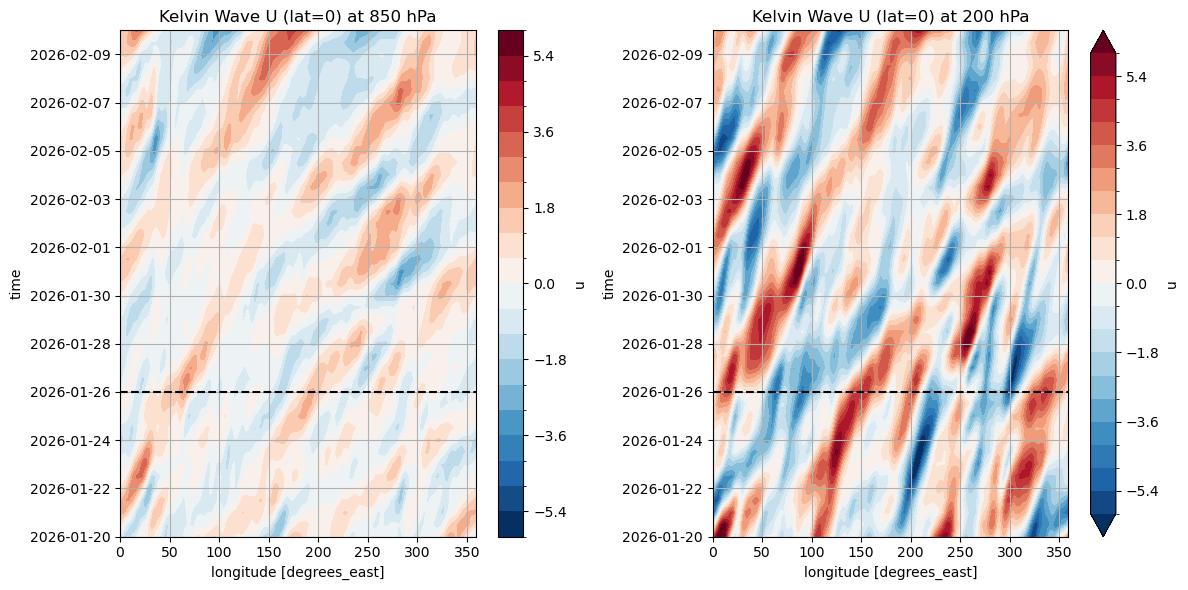

In [17]:
#plotting Kelvin wave equatorial zonal wind
fig,axs = plt.subplots(ncols=2,figsize=(12,6))
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=0,pressure=850).u.plot.contourf(levels=np.linspace(-6,6,21),ax=axs[0])
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=0,pressure=200).u.plot.contourf(levels=np.linspace(-6,6,21),ax=axs[1])
for ax,lev in zip(axs,[850,200]):
    ax.set_yticks(pd.date_range('2026-01-20','2026-02-10',freq='2D'))
    ax.grid()
    ax.axhline(np.datetime64('2026-01-26'),color='k',linestyle='dashed')
    ax.set_title(f'Kelvin Wave U (lat=0) at {lev} hPa')

plt.tight_layout()

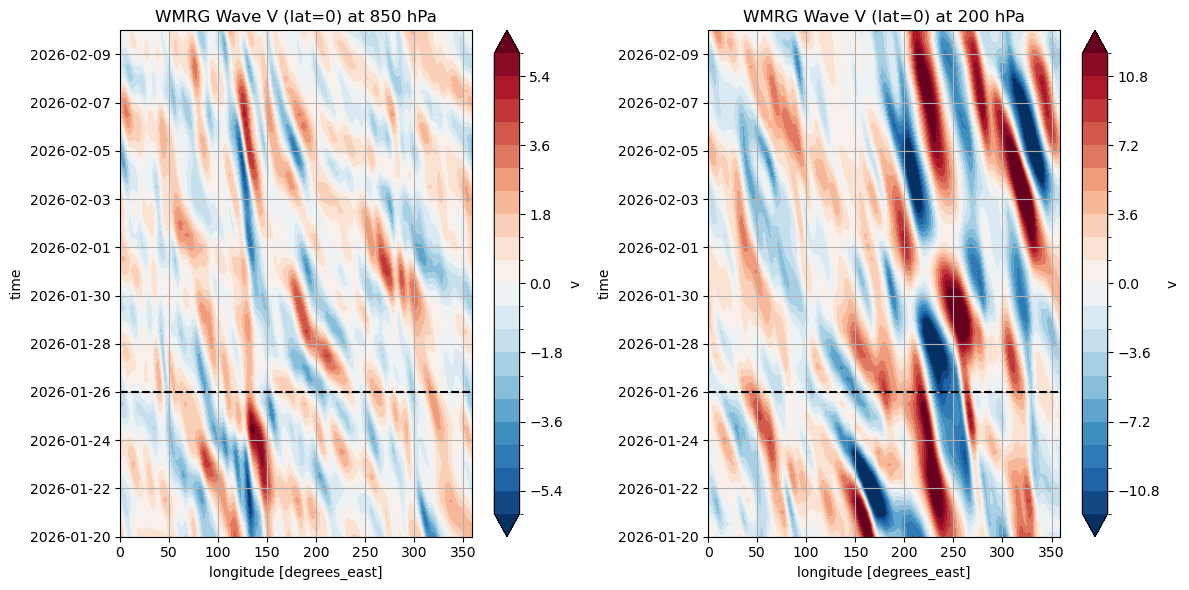

In [18]:
#plotting WMRG wave equatorial zonal wind
fig,axs = plt.subplots(ncols=2,figsize=(12,6))
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=1,pressure=850).v.plot.contourf(levels=np.linspace(-6,6,21),ax=axs[0])
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=1,pressure=200).v.plot.contourf(levels=np.linspace(-12,12,21),ax=axs[1])
for ax,lev in zip(axs,[850,200]):
    ax.set_yticks(pd.date_range('2026-01-20','2026-02-10',freq='2D'))
    ax.grid()
    ax.axhline(np.datetime64('2026-01-26'),color='k',linestyle='dashed')
    ax.set_title(f'WMRG Wave V (lat=0) at {lev} hPa')

plt.tight_layout()

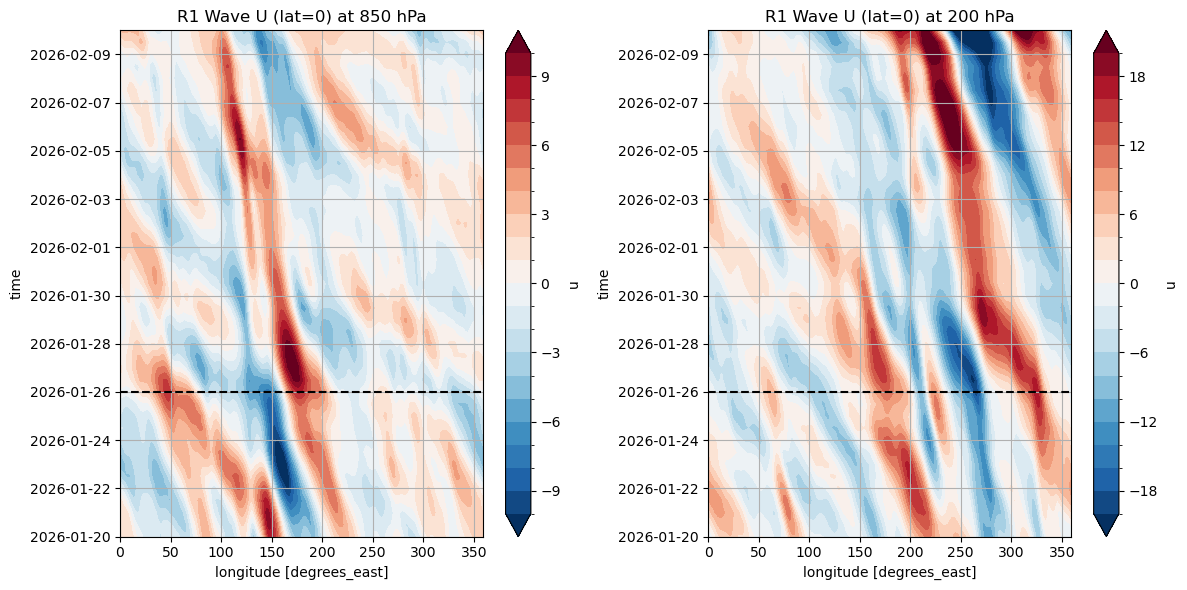

In [19]:
#plotting R1 wave equatorial zonal wind
fig,axs = plt.subplots(ncols=2,figsize=(12,6))
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=2,pressure=850).u.plot.contourf(levels=np.linspace(-10,10,21),ax=axs[0])
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=2,pressure=200).u.plot.contourf(levels=np.linspace(-20,20,21),ax=axs[1])
for ax,lev in zip(axs,[850,200]):
    ax.set_yticks(pd.date_range('2026-01-20','2026-02-10',freq='2D'))
    ax.grid()
    ax.axhline(np.datetime64('2026-01-26'),color='k',linestyle='dashed')
    ax.set_title(f'R1 Wave U (lat=0) at {lev} hPa')

plt.tight_layout()

# Calculate divergence and contour example

Calculate divergence using metpy. Can plot contour snapshots instead of hovmoller if required

In [ ]:
kelv_div = divergence(wave_ncs.u.sel(mode=0),xr.zeros_like(wave_ncs.u.sel(mode=0)))
kelv_div.name = 'div'
#r1_vor = vorticity(wave_ncs.u.sel(mode=2),wave_ncs.v.sel(mode=2))  #can include vorticity for R1 waves
#r1_vor.name = 'vor'  #commented for R1 waves

kelv_u = wave_ncs.u.sel(mode=0)
#r1_u = wave_ncs.v.sel(mode=2)  

kelv_v = xr.zeros_like(kelv_u)  #placeholder for v component, don't need to do for R1 and WMRG waves
kelv_v.name = 'v'
#r1_v = wave_ncs.v.sel(mode=2)  #can include v component for R1 waves

kelv850 = xr.merge([kelv_u,kelv_v,kelv_div])
#r1850 = xr.merge([r1_u,r1_v,r1_vor])  #for plotting R1 waves with vorticity, can do same for WMRG waves


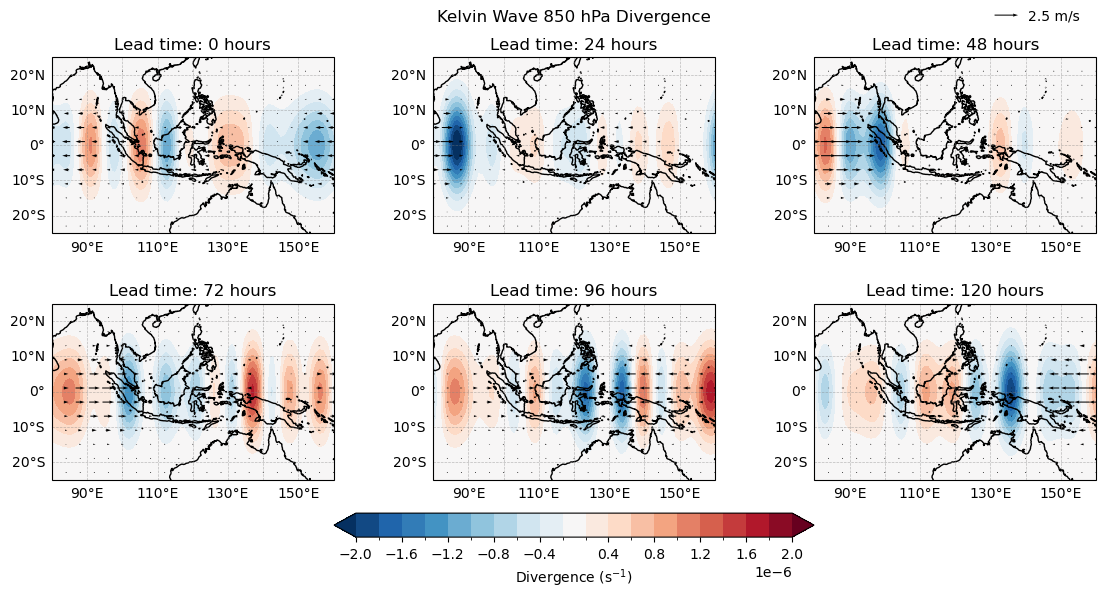

In [93]:
#850 hPa divergence for Kelvin wave from forecast initialisation onwards
kelv_fc = kelv850.sel(pressure=850,time=slice('2026-01-26',None))

#set up panels
fig,axs = plt.subplots(figsize=(12,6),ncols=3,nrows=2,
                       subplot_kw={'projection':ccrs.PlateCarree()},
                       gridspec_kw={'hspace':0.4,'wspace':0.2,'top':0.9,'bottom':.1,'left':0.05,'right':0.95})
axs = axs.flatten()

#divergence levels
levels = np.linspace(-2e-6,2e-6,21)
levels = list(filter(lambda x: x!=0,levels))

#for 6 lead times (0-120 hours)
for lead in range(0,6):
    ax = axs[lead]
    kelv_fc_lead = kelv_fc.isel(time=lead*2).sel(longitude=slice(80,160))

    #plot divergence
    cont = kelv_fc_lead.div.plot.contourf(levels=levels,ax=ax,
                               x='longitude',y='latitude',extend='both',
                               add_colorbar=False)
    
    #add wind vectors (subsampled for clarity)
    qu = kelv_fc_lead.isel(latitude=slice(None,None,4),longitude=slice(None,None,4)).plot.quiver(ax=ax, 
                        x='longitude', y='latitude', u='u', v='v',
                        scale=30, color='k',add_guide=False)
    
    #gridlines, title, coastlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.5,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f'Lead time: {lead*2*12} hours')
    ax.coastlines()

#add colorbar and overall title    
plt.suptitle('Kelvin Wave 850 hPa Divergence')
cbar = plt.colorbar(cont,ax = axs,orientation='horizontal',fraction=0.05,pad=0.07,label='Divergence (s$^{-1}$)')
cbar.ax.set_xticks(np.concatenate([np.arange(-2e-6,0,4e-7),np.arange(4e-7,2.1e-6,4e-7)]))
plt.quiverkey(qu,0.87, .97, 2.5, '2.5 m/s', labelpos='E', coordinates='figure')
plt.show()

# TEST: zeros in longitudes (for a subselection of data)

Data is made to be zeros for 240 degrees of the global domain to test the differences.

In [124]:
cos_decline = np.cos(np.linspace(np.deg2rad(0),np.deg2rad(90),12))
cos_increase = np.cos(np.linspace(np.deg2rad(270),np.deg2rad(360),12))


In [125]:
lon_taper = np.ones(360)
lon_taper[:60] = 0
lon_taper[60:72] = cos_increase
lon_taper[168:180] = cos_decline
lon_taper[180:] = 0


In [126]:
lon_taper = xr.DataArray(lon_taper,coords=[nc.longitude],dims=['longitude'])

In [127]:
nc_sub = nc*lon_taper

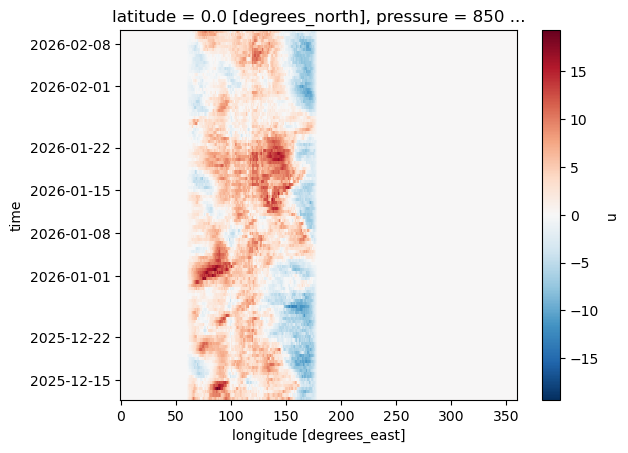

In [128]:
nc_sub.u.sel(pressure=850,latitude=0).plot()

In [129]:
wave_ncs_sub = W.filt_project_func(u=nc_sub.u,gh=nc_sub.gh,v=nc_sub.v,freq=.5,taper_days=6,taper_kind='start')

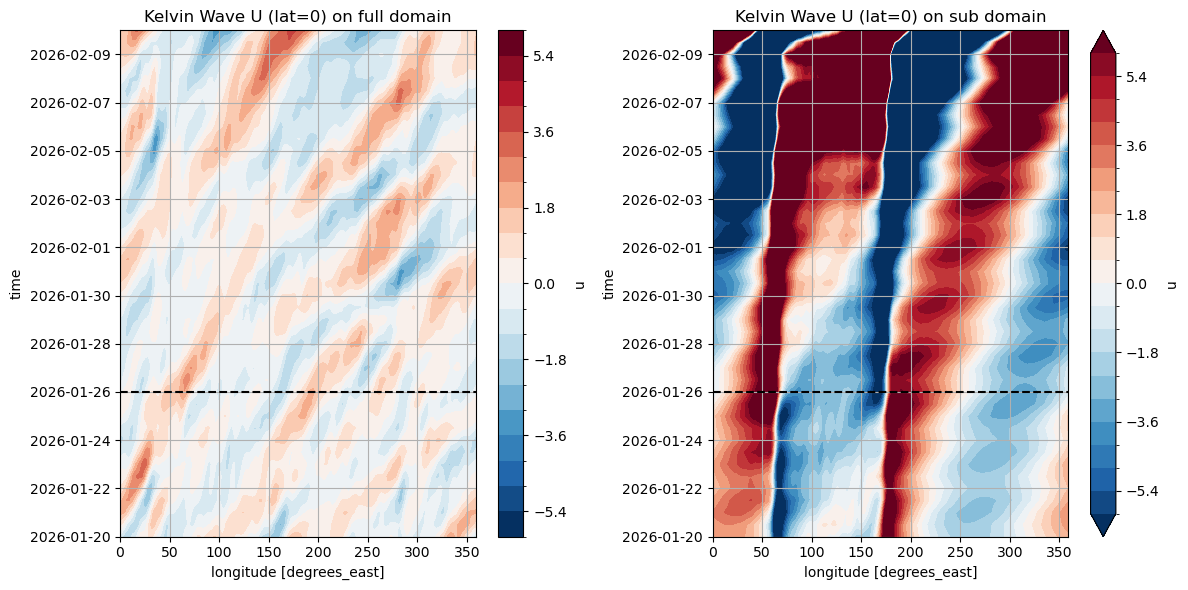

In [130]:
#plotting Kelvin wave equatorial zonal wind
fig,axs = plt.subplots(ncols=2,figsize=(12,6))
wave_ncs.sel(time=slice('2026-01-20',None),latitude=0,mode=0,pressure=850).u.plot.contourf(levels=np.linspace(-6,6,21),ax=axs[0])
wave_ncs_sub.sel(time=slice('2026-01-20',None),latitude=0,mode=0,pressure=850).u.plot.contourf(levels=np.linspace(-6,6,21),ax=axs[1])
for ax,domain in zip(axs,['full','sub']):
    ax.set_yticks(pd.date_range('2026-01-20','2026-02-10',freq='2D'))
    ax.grid()
    ax.axhline(np.datetime64('2026-01-26'),color='k',linestyle='dashed')
    ax.set_title(f'Kelvin Wave U (lat=0) on {domain} domain')

plt.tight_layout()